In [69]:
%matplotlib inline 
import keras as K
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GaussianNoise, Cropping2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.engine.input_layer import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard

from keras import backend as K

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05e7be16d8>,
      dtype=object)

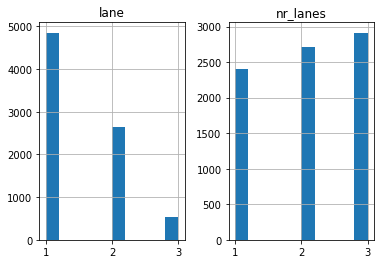

In [36]:
DATASET_CSV_PATH='bdd_train_set.csv'
MAX_NUMBER_OF_LANES=4

samples=pd.read_csv(DATASET_CSV_PATH)
samples=samples[samples['lane']>=0]
samples=samples[samples['lane']<MAX_NUMBER_OF_LANES]
samples=samples[samples['nr_lanes']>=0]
samples=samples[samples['nr_lanes']<MAX_NUMBER_OF_LANES]
nr_train_samples=int(len(samples)*TRAIN_VAL_RATIO)
samples.hist()



In [19]:
samples['lane'].value_counts()

1    4851
2    2646
3     535
Name: lane, dtype: int64

NameError: name 'train_samples' is not defined

In [52]:
train_samples=samples.groupby('lane').apply(pd.DataFrame.sample, n=len(samples),replace=True).reset_index(drop=True).sample(frac=1, replace=False)
train_samples['lane']=train_samples['lane'].astype('str')
#train_samples.head()
train_samples['lane'].value_counts()

1    8032
2    8032
3    8032
Name: lane, dtype: int64

In [53]:
train_samples.head()

,img_path,nr_lanes,lane
21369,bdd100k/images/100k/val/b3c0460d-33d7256d.jpg,3,3
19306,bdd100k/images/100k/train/730cb48f-c96430bf.jpg,3,3
18553,bdd100k/images/100k/train/3a6ae2aa-397c6af6.jpg,3,3
14726,bdd100k/images/100k/train/01a0fe55-298688cb.jpg,3,2
10528,bdd100k/images/100k/train/a5dd241e-f9c71d5c.jpg,2,2


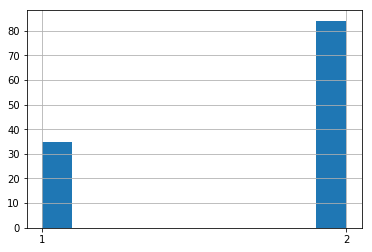

In [77]:
DATASET_CSV_PATH='val_data.csv'
MAX_NUMBER_OF_LANES=4

val_samples=pd.read_csv(DATASET_CSV_PATH)
val_samples=val_samples[val_samples['lane']>=0]
val_samples=val_samples[val_samples['lane']<MAX_NUMBER_OF_LANES]
val_samples=val_samples[val_samples['nr_lanes']>=0]
val_samples=val_samples[val_samples['nr_lanes']<MAX_NUMBER_OF_LANES]
val_samples['lane']=val_samples['lane'].astype('str')
nr_val_samples=len(val_samples)
val_samples['lane'].hist()

In [78]:
val_samples.head()

,img_path,nr_lanes,lane
0,val_data/image_080822-3-3.jpg,3,3
1,val_data/image_061569-3-2.jpg,3,2
2,val_data/image_042304-3-2.jpg,3,2
3,val_data/image_040711-3-1.jpg,3,1
4,val_data/image_084107-3-3.jpg,3,3


In [79]:
val_samples['lane'].value_counts()

2    50
1    35
3    34
Name: lane, dtype: int64

In [82]:
# dimensions of our images.
img_width, img_height = 640, 480
CROP_TOP=int(200)
CROP_BOTTOM=int(30)


nb_train_samples = nr_train_samples
nb_validation_samples = nr_val_samples
batch_size = 8

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)
    
model = Sequential()
model.add(Cropping2D(cropping=((CROP_TOP, CROP_BOTTOM), (0, 0)), input_shape=input_shape))
model.add(GaussianNoise(0.5))

#model.add(GaussianNoise(0.5, input_shape=input_shape))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

In [86]:
#model=darknet()
sgd = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.00001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_3 (Cropping2D)    (None, 250, 640, 3)       0         
_________________________________________________________________
gaussian_noise_8 (GaussianNo (None, 250, 640, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 248, 638, 128)     3584      
_________________________________________________________________
activation_36 (Activation)   (None, 248, 638, 128)     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 246, 636, 128)     147584    
_________________________________________________________________
activation_37 (Activation)   (None, 246, 636, 128)     0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 123, 318, 128)   

In [96]:
MODEL_SAVE_PATH='models/weights.{epoch:02d}-{val_loss:.2f}-{acc:.2f}.hdf5'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    shear_range=0.4,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=False,
    brightness_range=(0.25,1.85),
    channel_shift_range=130)
#)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator()

x_col='img_path'
y_col='lane'
train_generator = train_datagen.flow_from_dataframe(
    train_samples,
    x_col=x_col,
    y_col=y_col,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
    val_samples,
    x_col=x_col,
    y_col=y_col,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

callbacks = [#EarlyStopping(monitor='val_loss', patience=10),
             CSVLogger('./train.log', separator=',', append=False),
             #TensorBoard(log_dir='./tensorboard', histogram_freq=100, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch'),
             ModelCheckpoint(filepath=MODEL_SAVE_PATH, monitor='acc', verbose=True, save_best_only=False, mode='max')]

Found 24096 validated image filenames belonging to 3 classes.
Found 119 validated image filenames belonging to 3 classes.


[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]


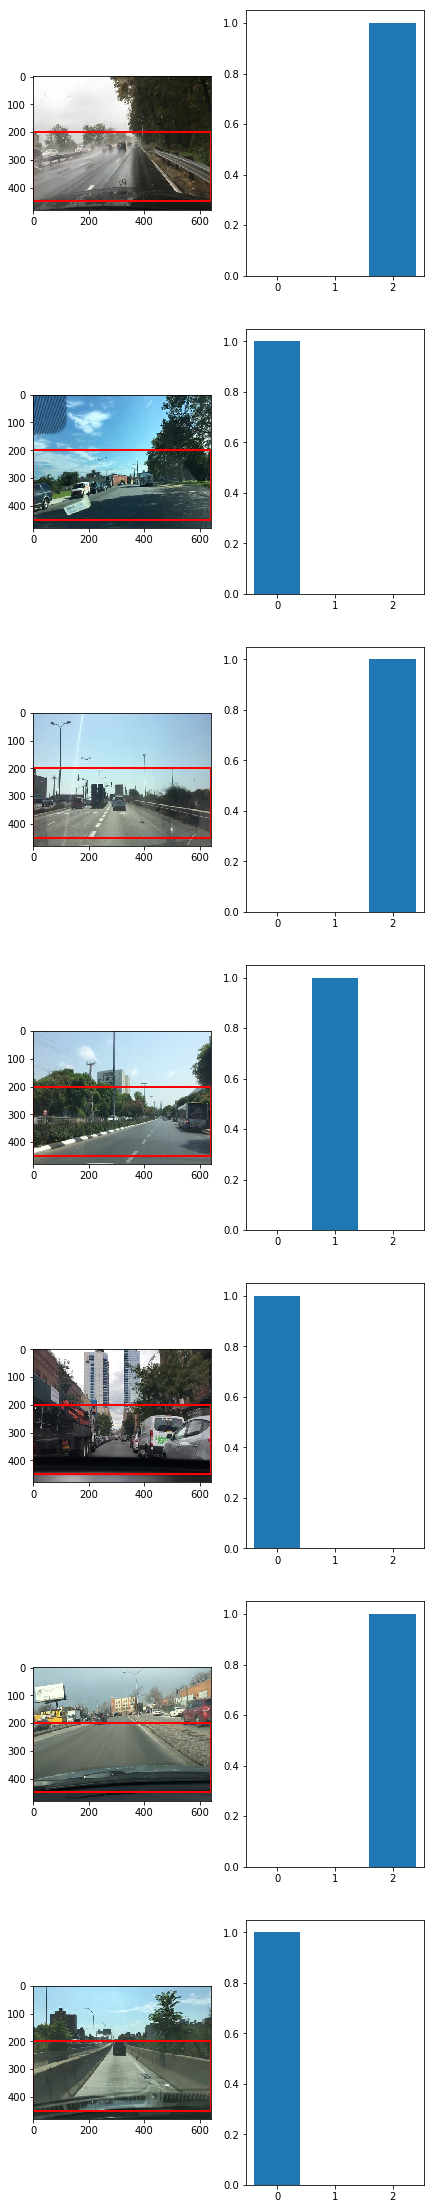

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
sample_data=next(train_generator)
sample_images=sample_data[0]
sample_images=sample_images.astype('uint8')
sample_lane_numbers=sample_data[1]

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(7,40))
rowid=0

for row in ax:
    rect = patches.Rectangle((0,CROP_TOP),img_width,img_height-CROP_BOTTOM-CROP_TOP,linewidth=2,edgecolor='r',facecolor='none')
    row[0].add_patch(rect)
    row[0].imshow(sample_images[rowid])
    print(sample_lane_numbers[rowid])
    row[1].bar([0,1,2], sample_lane_numbers[rowid])
    rowid=rowid+1

In [34]:
sample_images[0]


array([[[213, 255, 255],
        [213, 255, 255],
        [213, 255, 255],
        ..., 
        [215, 207, 188],
        [215, 207, 188],
        [215, 207, 188]],

       [[213, 255, 255],
        [213, 255, 255],
        [213, 255, 255],
        ..., 
        [215, 207, 188],
        [215, 207, 188],
        [215, 207, 188]],

       [[213, 255, 255],
        [213, 255, 255],
        [213, 255, 255],
        ..., 
        [215, 207, 188],
        [215, 207, 188],
        [215, 207, 188]],

       ..., 
       [[216, 212, 213],
        [209, 205, 206],
        [209, 205, 206],
        ..., 
        [123, 122, 127],
        [123, 122, 127],
        [123, 122, 127]],

       [[222, 218, 219],
        [211, 207, 208],
        [207, 203, 204],
        ..., 
        [123, 122, 127],
        [123, 122, 127],
        [123, 122, 127]],

       [[217, 213, 214],
        [214, 210, 211],
        [212, 208, 209],
        ..., 
        [123, 122, 127],
        [123, 122, 127],
        [123, 122,

In [93]:
epochs = 1000
iters_per_epoch=200
model.fit_generator(
    train_generator,
    callbacks=callbacks,
    steps_per_epoch=iters_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=200,
    max_queue_size=64,
    workers=24,
    use_multiprocessing=True)

Epoch 1/1000
  9/200 [>.............................] - ETA: 20:29 - loss: 2.6237 - acc: 0.3750

Process ForkPoolWorker-140:
Process ForkPoolWorker-117:
Process ForkPoolWorker-111:
Process ForkPoolWorker-104:
Process ForkPoolWorker-116:
Process ForkPoolWorker-141:
Process ForkPoolWorker-142:
Process ForkPoolWorker-113:
Process ForkPoolWorker-97:
Process ForkPoolWorker-128:
Process ForkPoolWorker-124:
Process ForkPoolWorker-107:
Process ForkPoolWorker-127:
Process ForkPoolWorker-102:
Process ForkPoolWorker-115:
Process ForkPoolWorker-144:
Process ForkPoolWorker-106:
Process ForkPoolWorker-109:
Process ForkPoolWorker-120:
Process ForkPoolWorker-99:
Process ForkPoolWorker-138:
Process ForkPoolWorker-126:
Process ForkPoolWorker-101:
Process ForkPoolWorker-143:
Process ForkPoolWorker-129:
Process ForkPoolWorker-112:
Process ForkPoolWorker-98:
Process ForkPoolWorker-123:
Process ForkPoolWorker-121:
Process ForkPoolWorker-100:
Process ForkPoolWorker-139:
Process ForkPoolWorker-137:
Process ForkPoolWorker-122:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback

  File "/usr/lib64/python3.4/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.4/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.4/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib64/python3.4/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.4/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.4/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/lib64/python3.4/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.4/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.4/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.4/multiprocessin

  File "/usr/lib64/python3.4/multiprocessing/queues.py", line 359, in get
    with self._rlock:
  File "/usr/lib64/python3.4/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.4/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/lib64/python3.4/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.4/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.4/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib64/python3.4/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.4/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.4/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/lib64/python

KeyboardInterrupt: 